In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import numpy as np

from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
import seaborn as sns

/home/mojo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.5)

In [3]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).view(-1,1)

# X_test = torch.FloatTensor(X_test)
# y_test = torch.FloatTensor(y_test).view(-1,1)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
# test_data = torch.utils.data.TensorDataset(X_test, y_test)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=500)

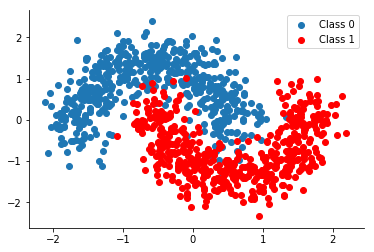

In [4]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()

In [5]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = torch.FloatTensor(grid.reshape(2, -1).T)
dummy_out = torch.tensor(np.ones(grid_2d.shape))

In [6]:
test_data = torch.utils.data.TensorDataset(grid_2d, dummy_out)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10000)

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(2, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50,2, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [19]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr = 1e-4



batch_size = 32
dataset_size= 500.

network = Model()
criterion = nn.BCEWithLogitsLoss(size_average=False)

optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)

#evaluate = evaluation(test_loader, 4.5, X_train_mean, X_train_std, y_train_mean, y_train_std)

losses_sgld = []
test_rmse = []
log_lik_sgld = []
n_samples = 200
t = 1.
n = 0
predictions = torch.zeros(10000,n_samples)

for epoch in range(200):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)
        one_hot = torch.zeros(x.size(0),2).scatter_(1,y.view(-1,1).long(),1)

        network.zero_grad()
        output = network(x)
        loss = criterion(output, one_hot)
        loss.backward()
        optim.step()


       
        running_loss += loss * batch_size / dataset_size


        if (t >= 300) & (t % 10 == 0) & (n < n_samples):
            accuracy = 0
            with torch.autograd.no_grad():
                for x, y in iter(test_loader):
                    output = network(x)
                    output = F.sigmoid(output)
                    prediction = output.data.max(1)[1].view(-1,1)
                    
                    #accuracy = torch.sum(prediction.eq(y.long())).float() / 500
                    predictions[:,n] = prediction.view(-1,)
                    print("Accuracy: {:.4f}".format(accuracy))
                    n += 1
#            rmse, log_lik, predictions = evaluate.fn(network)

#                rmse, log_lik = evaluate(network, test_loader, tau, T, y_train_mean, y_train_std)
#            test_rmse.append(rmse)
#            log_lik_sgld.append(log_lik)
        
        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 28.9417
Epoch 1 - loss: 19.5462
Epoch 2 - loss: 19.0674
Epoch 3 - loss: 18.8266
Epoch 4 - loss: 18.7748
Epoch 5 - loss: 18.4911
Epoch 6 - loss: 18.0282
Epoch 7 - loss: 17.8257
Epoch 8 - loss: 16.9443
Epoch 9 - loss: 16.3646
Epoch 10 - loss: 16.4500
Epoch 11 - loss: 15.8473
Epoch 12 - loss: 15.2617
Epoch 13 - loss: 14.4411
Epoch 14 - loss: 14.1803
Epoch 15 - loss: 13.3634
Epoch 16 - loss: 12.2208
Epoch 17 - loss: 11.5977


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy: 0.0000
Epoch 18 - loss: 11.0512
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 19 - loss: 10.5955
Accuracy: 0.0000
Epoch 20 - loss: 10.0793
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 21 - loss: 9.5344
Accuracy: 0.0000
Epoch 22 - loss: 9.7640
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 23 - loss: 8.8998
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 24 - loss: 8.6643
Accuracy: 0.0000
Epoch 25 - loss: 9.1974
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 26 - loss: 8.3574
Accuracy: 0.0000
Epoch 27 - loss: 8.1027
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 28 - loss: 7.9849
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 29 - loss: 8.3481
Accuracy: 0.0000
Epoch 30 - loss: 8.2794
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 31 - loss: 8.3688
Accuracy: 0.0000
Epoch 32 - loss: 7.5849
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 33 - loss: 8.3257
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 34 - loss: 8.5901
Accuracy: 0.0000
Epoch 35 - loss: 9.2089
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 36 - loss: 8.6860
Accuracy: 0.0000
Epoch 37 - los

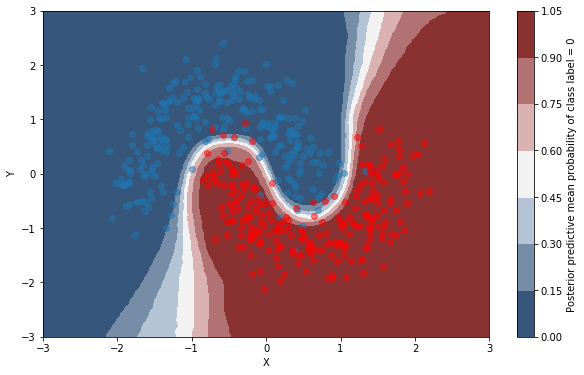

In [20]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().mean(1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

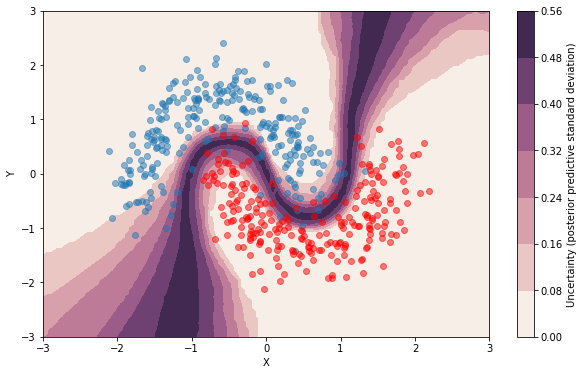

In [21]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().std(axis=1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [30]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr = 1e-2
alpha = 0.99



batch_size = 32
dataset_size= 500.

network = Model()
criterion = nn.BCEWithLogitsLoss(size_average=False)

optim = psgld.optim.psgld(network, lr, alpha,lambda_, batch_size, dataset_size)

#evaluate = evaluation(test_loader, 4.5, X_train_mean, X_train_std, y_train_mean, y_train_std)

n_samples = 200
t = 1.
n = 0
predictions = torch.zeros(10000,n_samples)

for epoch in range(200):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)
        one_hot = torch.zeros(x.size(0),2).scatter_(1,y.view(-1,1).long(),1)

        network.zero_grad()
        output = network(x)
        loss = criterion(output, one_hot)
        loss.backward()
        optim.step()


       
        running_loss += loss * batch_size / dataset_size


        if (t >= 300) & (t % 10 == 0) & (n < n_samples):
            accuracy = 0
            with torch.autograd.no_grad():
                for x, y in iter(test_loader):
                    output = network(x)
                    output = F.sigmoid(output)
                    prediction = output.data.max(1)[1].view(-1,1)
                    
                    #accuracy = torch.sum(prediction.eq(y.long())).float() / 500
                    predictions[:,n] = prediction.view(-1,)
                    print("Accuracy: {:.4f}".format(accuracy))
                    n += 1
#            rmse, log_lik, predictions = evaluate.fn(network)

#                rmse, log_lik = evaluate(network, test_loader, tau, T, y_train_mean, y_train_std)
#            test_rmse.append(rmse)
#            log_lik_sgld.append(log_lik)
        
        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 252.6523
Epoch 1 - loss: 13.1870
Epoch 2 - loss: 17.2670
Epoch 3 - loss: 13.3399
Epoch 4 - loss: 10.9464
Epoch 5 - loss: 12.2344
Epoch 6 - loss: 11.5441
Epoch 7 - loss: 11.4986
Epoch 8 - loss: 9.2978
Epoch 9 - loss: 12.2425
Epoch 10 - loss: 9.5350
Epoch 11 - loss: 9.1070
Epoch 12 - loss: 10.9625
Epoch 13 - loss: 11.5270
Epoch 14 - loss: 11.1897
Epoch 15 - loss: 15.3529
Epoch 16 - loss: 10.6750
Epoch 17 - loss: 10.9117


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy: 0.0000
Epoch 18 - loss: 10.2427
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 19 - loss: 8.8932
Accuracy: 0.0000
Epoch 20 - loss: 10.4399
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 21 - loss: 10.6525
Accuracy: 0.0000
Epoch 22 - loss: 9.8948
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 23 - loss: 10.5845
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 24 - loss: 20.1401
Accuracy: 0.0000
Epoch 25 - loss: 10.1976
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 26 - loss: 10.4121
Accuracy: 0.0000
Epoch 27 - loss: 14.6038
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 28 - loss: 10.6117
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 29 - loss: 8.8297
Accuracy: 0.0000
Epoch 30 - loss: 9.8209
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 31 - loss: 10.2185
Accuracy: 0.0000
Epoch 32 - loss: 9.3842
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 33 - loss: 10.8503
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 34 - loss: 8.7792
Accuracy: 0.0000
Epoch 35 - loss: 8.0992
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 36 - loss: 8.7503
Accuracy: 0.0000
Epoch 

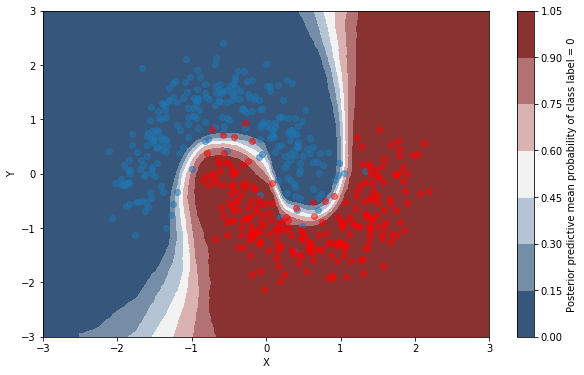

In [31]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().mean(1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

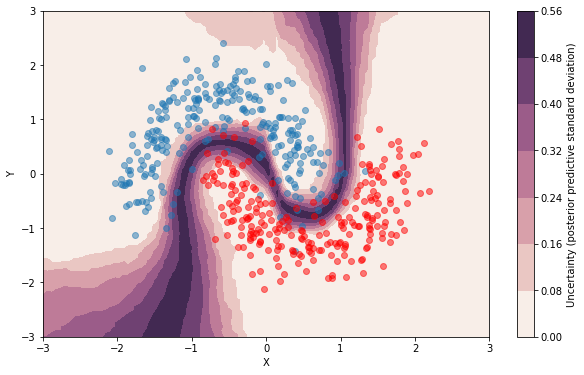

In [32]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().std(axis=1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [9]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr = 1e-2



batch_size = 32
dataset_size= 500.

network = Model()
criterion = nn.BCEWithLogitsLoss(size_average=False)

optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon= 0.01, l2=1e-3, invert_every=1)




n_samples = 200
t = 1.
n = 0
predictions = torch.zeros(10000,n_samples)

for epoch in range(200):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)
        one_hot = torch.zeros(x.size(0),2).scatter_(1,y.view(-1,1).long(),1)
        
        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = criterion(output, one_hot)
        loss.backward()
        optim.step()


       
        running_loss += loss * batch_size / dataset_size


        if (t >= 300) & (t % 10 == 0) & (n < n_samples):
            accuracy = 0
            with torch.autograd.no_grad():
                for x, y in iter(test_loader):
                    output = network(x)
                    output = F.sigmoid(output)
                    prediction = output.data.max(1)[1].view(-1,1)

                    predictions[:,n] = prediction.view(-1,)
                    print("Accuracy: {:.4f}".format(accuracy))
                    n += 1

        
        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 36.4061
Epoch 1 - loss: 24.9993
Epoch 2 - loss: 21.1022
Epoch 3 - loss: 19.6626
Epoch 4 - loss: 19.0789
Epoch 5 - loss: 18.6635
Epoch 6 - loss: 18.3780
Epoch 7 - loss: 18.1957
Epoch 8 - loss: 17.9319
Epoch 9 - loss: 17.6939
Epoch 10 - loss: 17.4052
Epoch 11 - loss: 17.0651
Epoch 12 - loss: 16.7484
Epoch 13 - loss: 16.3256
Epoch 14 - loss: 16.0050
Epoch 15 - loss: 15.4259
Epoch 16 - loss: 14.9885
Epoch 17 - loss: 14.3449
Accuracy: 0.0000
Epoch 18 - loss: 13.6940
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 19 - loss: 12.9990
Accuracy: 0.0000
Epoch 20 - loss: 12.3706
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 21 - loss: 11.4813
Accuracy: 0.0000
Epoch 22 - loss: 10.7774
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 23 - loss: 10.0879
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 24 - loss: 9.4419
Accuracy: 0.0000
Epoch 25 - loss: 8.9367
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 26 - loss: 8.2323
Accuracy: 0.0000
Epoch 27 - loss: 7.8945
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 28 - loss: 7.6277
A

Epoch 197 - loss: 5.4797
Epoch 198 - loss: 5.9458
Epoch 199 - loss: 5.4212


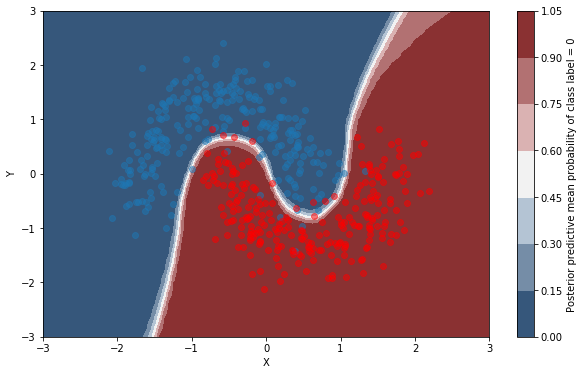

In [10]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().mean(1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)

cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

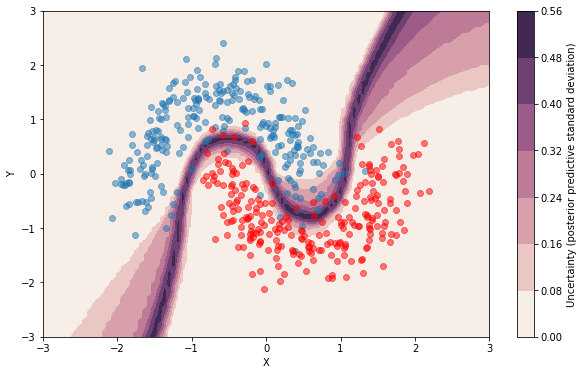

In [11]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().std(axis=1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [15]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr = 1e-2



batch_size = 32
dataset_size= 500.

network = Model()
criterion = nn.BCEWithLogitsLoss(size_average=False)

optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon= 1e-3, l2=1e-3, invert_every=1)




n_samples = 200
t = 1.
n = 0
predictions = torch.zeros(10000,n_samples)

for epoch in range(200):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)
        one_hot = torch.zeros(x.size(0),2).scatter_(1,y.view(-1,1).long(),1)
        
        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = criterion(output, one_hot)
        loss.backward()
        optim.step()


       
        running_loss += loss * batch_size / dataset_size


        if (t >= 300) & (t % 10 == 0) & (n < n_samples):
            accuracy = 0
            with torch.autograd.no_grad():
                for x, y in iter(test_loader):
                    output = network(x)
                    output = F.sigmoid(output)
                    prediction = output.data.max(1)[1].view(-1,1)

                    predictions[:,n] = prediction.view(-1,)
                    print("Accuracy: {:.4f}".format(accuracy))
                    n += 1

        
        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 33.0976
Epoch 1 - loss: 22.6270
Epoch 2 - loss: 19.7408
Epoch 3 - loss: 19.1812
Epoch 4 - loss: 20.3750
Epoch 5 - loss: 22.4669
Epoch 6 - loss: 22.5710
Epoch 7 - loss: 20.0711
Epoch 8 - loss: 23.5698
Epoch 9 - loss: 24.3220
Epoch 10 - loss: 36.8979
Epoch 11 - loss: 23.5547
Epoch 12 - loss: 30.3990
Epoch 13 - loss: 26.8805
Epoch 14 - loss: 23.6087
Epoch 15 - loss: 24.6037
Epoch 16 - loss: 30.2627
Epoch 17 - loss: 45.1314
Accuracy: 0.0000
Epoch 18 - loss: 38.6486
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 19 - loss: 59.9776
Accuracy: 0.0000
Epoch 20 - loss: 27.3098
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 21 - loss: 106.3309
Accuracy: 0.0000
Epoch 22 - loss: 36.7960
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 23 - loss: 42.4233
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 24 - loss: 32.8081
Accuracy: 0.0000
Epoch 25 - loss: 62.7074
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 26 - loss: 46.3471
Accuracy: 0.0000
Epoch 27 - loss: 54.6752
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 28 - loss: 37.

Epoch 189 - loss: 53.5325
Epoch 190 - loss: 67.0422
Epoch 191 - loss: 54.0256
Epoch 192 - loss: 31.3126
Epoch 193 - loss: 17.7261
Epoch 194 - loss: 17.6762
Epoch 195 - loss: 12.7346
Epoch 196 - loss: 15.2218
Epoch 197 - loss: 17.6804
Epoch 198 - loss: 15.9191
Epoch 199 - loss: 16.4655


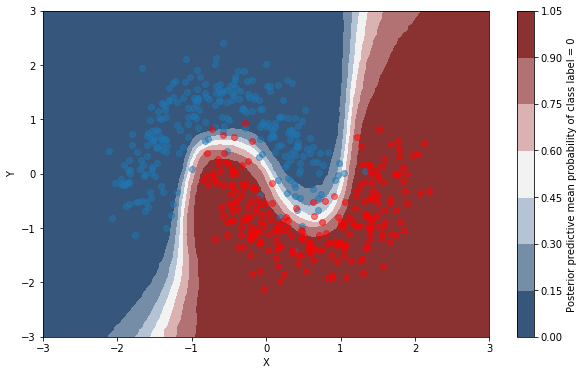

In [16]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().mean(1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

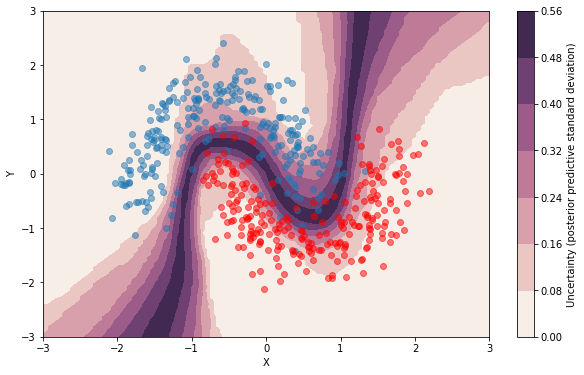

In [17]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().std(axis=1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');